In [1]:
%load_ext autoreload
%autoreload

import io
import os
import sys
import django
import glob
import json
import re
import requests
from IPython.core.debugger import set_trace
from pathlib import Path
from django.core.files.base import ContentFile
from rest_framework import serializers
from tqdm.notebook import tqdm
from google.cloud import vision
from google.cloud import storage
from PIL import Image, ImageSequence
from gensim.models import Doc2Vec
from IPython.core.debugger import set_trace
import IPython
import collections
from googletrans import Translator
from google.cloud import translate_v2 as translate

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parentdir)
django.setup()

import getch.models as m
from django.db.models import Q
from django.apps import apps
from django_currentuser.middleware import get_current_user

model_path = 'doc2vec.model'
d2v = Doc2Vec.load(model_path)

In [22]:
# django를 불러오면 아래를 굳이 부를필요 없는듯
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.abspath(os.path.join(os.getcwd(), 'sideb-proejct-0e33d8c0b0a9.json'))

In [2]:
def detect_labels(localpath=None, url=None, min_score=None):
    client = vision.ImageAnnotatorClient()

    if localpath:
        with io.open(localpath, 'rb') as image_file:
            content = image_file.read() 

        image = vision.Image(content=content)

    else:
        image = vision.Image()
        image.source.image_uri = url
        
        # 장고 이미지필드의 경우, 아래처럼도 가능
        # image = vision.Image(content=_post.pix.read())
    
    response = client.label_detection(image=image, max_results=50)
    labels = response.label_annotations
    labels = [label.description.lower() for label in labels if label.score>=min_score]
    #labels = [label.description.lower().replace(' ', '_') for label in labels]
    return labels

In [3]:
client = translate.Client()

def documented(labels):
    translated = client.translate(labels, source_language='en', target_language='ko')
    _labels = [_lab.replace(' ', '_') for _lab in labels]
    _translated = [_trans['translatedText'].replace(' ', '') for _trans in translated]
    
    if 'sneakers' in _labels:
        _translated.append('스니커즈')
        
    return ' '.join(_labels + _translated)

In [4]:
def preproc(text, remove_url=True, remove_mention=False, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = '((?: rt)|(?:^rt))[^ @]?'
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    SPECIALS = r'([^ a-zA-Z0-9_\u3131-\u3163\uac00-\ud7a3]+)|([ㄱ-ㅣ]+)'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    text = text.lower()
    
    if remove_url:
        text = re.sub(URL, ' ', text)

    if remove_mention:
        text = re.sub(MENTION, ' ', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, ' ', text)
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), ' ', text)
    return re.sub(LONG_BLANK, ' ', text).strip()


def get_url(text):
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    text = text.lower()
    return re.findall(URL, text)


def url_removed(text):
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    text = text.lower()
    return re.sub(URL, ' ', text).strip()

In [27]:
# _post = m.Post.objects.select_subclasses()[0]; _post
# _post = m.PostVoteAB.objects.filter(pixlabel_a='장희령 스탈'); _post
# _post = m.PostVoteAB.objects.filter(pixlabel_a='Gyakusou')[0]; _post
# _post = m.PostQA.objects.get(text__contains='놈코어 브랜드'); _post
_post = m.PostQA.objects.last(); _post

<PostQA: QA | 2021-03-23 21:11:10.733718 | sneakers_fan | magrittelim@gmail.com>

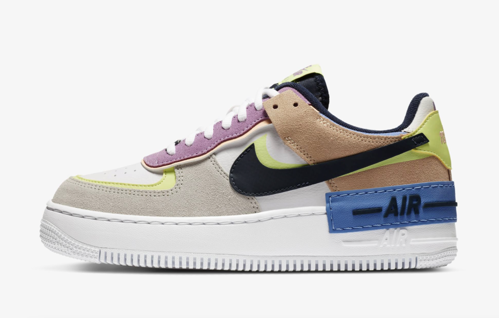

In [28]:
# path = '신발신발.png'
path = _post.pix
img = Image.open(path)
img.resize((int(img.width / 2), int(img.height / 2)))

In [29]:
labels = detect_labels(url=_post.pix.url, min_score=0.6); labels

['footwear',
 'shoe',
 'walking shoe',
 'sportswear',
 'grey',
 'outdoor shoe',
 'font',
 'sneakers',
 'electric blue',
 'athletic shoe',
 'magenta',
 'pattern',
 'design',
 'carmine',
 'rectangle',
 'brand',
 'slope',
 'skate shoe']

In [30]:
documented(labels)

'footwear shoe walking_shoe sportswear grey outdoor_shoe font sneakers electric_blue athletic_shoe magenta pattern design carmine rectangle brand slope skate_shoe 신발류 구두 걷는신발 운동복 회색 야외신발 폰트 운동화 강청색 운동화 마젠타 무늬 디자인 카민 직사각형 상표 경사 스케이트신발 스니커즈'

In [31]:
_post.text

'나이키 Nike | 스니커즈 운동화 에어포스원 포스원 코트화 화이트\n\nhttps://www.nike.com/kr/ko_kr/w/xg/fw/nsw/air-force-1-collection'

In [34]:
documented(labels) + ' ' + preproc(_post.text)

'footwear shoe walking_shoe sportswear grey outdoor_shoe font sneakers electric_blue athletic_shoe magenta pattern design carmine rectangle brand slope skate_shoe 신발류 구두 걷는신발 운동복 회색 야외신발 폰트 운동화 강청색 운동화 마젠타 무늬 디자인 카민 직사각형 상표 경사 스케이트신발 스니커즈 나이키 nike 스니커즈 운동화 에어포스원 포스원 코트화 화이트'

In [10]:
_pixs = m.Pix.objects.values_list('src', flat=True);

In [11]:
m.PostQA.objects.count(), m.PostQA.objects.exclude(pix__in=_pixs).count()

(4297, 214)

In [12]:
postqas = m.PostQA.objects.exclude(pix__in=_pixs)

In [13]:
postqas.count()

214

In [14]:
for _p in tqdm(postqas.order_by('id')[:]):    #과거부터 하는게 나중을 위해 낫겠다....
    #print(_p.pix, '*****')
    if not _p.pix: continue
        
    labels = detect_labels(url=_p.pix.url, min_score=0.6)

    pix = m.Pix()
    pix.owner = _p.boo
    pix.src = _p.pix
    
    #print(_p.text)
    pix.desc = url_removed(_p.text) if _p.text else ''
    _label = documented(labels) if len(labels)>0 else ''
    _desc = preproc(_p.text) if _p.text else ''
    pix.tokens = _label + ('' if _desc=='' else ' ') + _desc

    urls = get_url(_p.text) if _p.text else []
    if len(urls)>0: pix.outlink = urls[0]
    #print(urls)
    pix.save()
    
    _collection, _ = m.Collection.objects.get_or_create(name=pix.owner.nick+'님의 옷장', owner_id=pix.owner.id)
    m.Pick.objects.create(pix=pix, collection=_collection)
    #break

  0%|          | 0/214 [00:00<?, ?it/s]

In [71]:
#2958중 1697 하다가 에러남

In [49]:
# https://github.com/ssut/py-googletrans
# translator = Translator(service_urls=['translate.googleapis.com','translate.google.com','translate.google.co.kr'])
# result = translator.translate(det, src='en', dest="ko")
# result.text

# testify

In [12]:
def preproc(text, remove_url=True, remove_mention=False, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = '((?: rt)|(?:^rt))[^ @]?'
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    SPECIALS = r'([^ a-zA-Z0-9_\u3131-\u3163\uac00-\ud7a3]+)|([ㄱ-ㅣ]+)'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    text = text.lower()
    
    if remove_url:
        text = re.sub(URL, ' ', text)

    if remove_mention:
        text = re.sub(MENTION, ' ', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, ' ', text)
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), ' ', text)
    return re.sub(LONG_BLANK, ' ', text).strip()


def get_url(text):
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    text = text.lower()
    return re.findall(URL, text)


def url_removed(text):
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    text = text.lower()
    return re.sub(URL, ' ', text).strip()

In [48]:
get_url(_post.text)

['https://nastykick-shop.com/product/list.html?cate_no=74']

In [21]:
def detect_web(localpath=None, url=None):
    client = vision.ImageAnnotatorClient()

    if localpath:
        with io.open(localpath, 'rb') as image_file:
            content = image_file.read() 

        image = vision.Image(content=content)

    else:
        image = vision.Image()
        image.source.image_uri = url

    response = client.web_detection(image=image)
    annotations = response.web_detection

    if annotations.best_guess_labels:
        for label in annotations.best_guess_labels:
            print('\nBest guess label: {}'.format(label.label))

    if annotations.pages_with_matching_images:
        print('\n{} Pages with matching images found:'.format(
            len(annotations.pages_with_matching_images)))

        for page in annotations.pages_with_matching_images:
            print('\n\tPage url   : {}'.format(page.url))

            if page.full_matching_images:
                print('\t{} Full Matches found: '.format(
                       len(page.full_matching_images)))

                for image in page.full_matching_images:
                    print('\t\tImage url  : {}'.format(image.url))

            if page.partial_matching_images:
                print('\t{} Partial Matches found: '.format(
                       len(page.partial_matching_images)))

                for image in page.partial_matching_images:
                    print('\t\tImage url  : {}'.format(image.url))

    if annotations.web_entities:
        print('\n{} Web entities found: '.format(
            len(annotations.web_entities)))

        for entity in annotations.web_entities:
            print('\n\tScore      : {}'.format(entity.score))
            print(u'\tDescription: {}'.format(entity.description))

    if annotations.visually_similar_images:
        print('\n{} visually similar images found:\n'.format(
            len(annotations.visually_similar_images)))

        for image in annotations.visually_similar_images:
            print('\tImage url    : {}'.format(image.url))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return annotations

In [7]:
last.above(first)

In [12]:
first.previous()

In [3]:
for pix in tqdm(m.Pix.objects.all()[:]):
    _collection, _ = m.Collection.objects.get_or_create(name=pix.owner.nick+'님의 옷장', owner_id=pix.owner.id)
    m.Pick.objects.create(pix=pix, collection=_collection)

  0%|          | 0/690 [00:00<?, ?it/s]

In [18]:
for _pix in tqdm(m.Pix.objects.order_by('id')):
    if _pix.outlink:
        _pix.desc = url_removed(_pix.desc)
        _pix.save()

  0%|          | 0/690 [00:00<?, ?it/s]

In [10]:
m.PostQA.objects.order_by('id').first().pix

<ImageFieldFile: post/2021/1/21/quantlab@kakao.com/2021-01-21_055900.540630__서비스_이용에_불편을_드려서_죄송합니다.png>

In [8]:
m.Pix.objects.filter(src=_pixsrc.name)

<QuerySet []>

In [4]:
str(_pixsrc.name)

'post/2021/1/21/quantlab@kakao.com/2021-01-21_055900.540630__서비스_이용에_불편을_드려서_죄송합니다.png'

In [6]:
m.Pix.objects.first().src.name

'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115444.089782__blob'

In [15]:
m.Pix.objects.filter(owner__nick='아이쿠야').first().id

722

<QuerySet ['post/2021/3/10/kiwi9621@yonsei.ac.kr/2021-03-10_112358.885134__blob', 'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115406.874423__blob', 'post/2021/3/11/magrittelim@gmail.com/2021-03-11_152830.829702__blob', 'post/2021/3/11/magrittelim@gmail.com/2021-03-11_152733.625304__blob', 'post/2021/3/11/kiwi9621@yonsei.ac.kr/2021-03-11_151244.091408__blob', 'post/2021/3/11/kiwi9621@yonsei.ac.kr/2021-03-11_151206.200661__blob', 'post/2021/3/11/kiwi9621@yonsei.ac.kr/2021-03-11_151132.701769__blob', 'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115344.522089__blob', 'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115329.402629__blob', 'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115317.315948__blob', 'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115307.099715__blob', 'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115251.692073__blob', 'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115215.802760__blob', 'post/2021/3/12/magrittelim@gmail.com/2021-03-12_115025.602337__bl

In [22]:
m.PostQA.objects.filter(pix__in=_pixs).count()

689